In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()  # for plot styling
from sklearn.cluster import KMeans
from pandas import DataFrame
import random
from sklearn.datasets.samples_generator import make_blobs
from scipy.stats import skewnorm
import uproot
import time
import math as m

/home/santilor/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
f = uproot.open('/home/santilor/GPU_SupRes/PFlowNtupleFile_HOMDet_2to5GeV_Overlap_WS.root')
f['EventTree'].keys()


[b'new_v',
 b'Cell_E',
 b'Total_Ch_Energy',
 b'Total_Nu_Energy',
 b'True_Ch_Energy',
 b'True_Nu_Energy',
 b'Smeared_Ch_Energy',
 b'Trk_X_indx',
 b'Trk_Y_indx',
 b'Trk_X_pos',
 b'Trk_Y_pos',
 b'Trk_Theta',
 b'Trk_Phi',
 b'Pi0_X_pos',
 b'Pi0_Y_pos',
 b'Pi0_Theta',
 b'Pi0_Phi',
 b'Photon1_E',
 b'Photon2_E',
 b'Photon1_Theta',
 b'Photon2_Theta',
 b'Photon1_Phi',
 b'Photon2_Phi',
 b'cell_Energy',
 b'cellCh_Energy',
 b'cellNu_Energy',
 b'Noise_cell_Energy']

In [3]:
true_pix, orig_pix, det_size = 128, 64, 125.
LayerPix = np.array([64, 32, 32, 16, 16, 8])
NEvent = 1000

#dim in cm 
X_0=3.9
l_I=17.4
orig=150
length=np.array([3*X_0,16*X_0,6*X_0,1.5*l_I,4.1*l_I,1.8*l_I])
print("Layers depth: ",length)

orig_b=150

Z=np.array([l/2. for l in length])
Z=orig_b+np.array([Z[0], 2*Z[0]+Z[1], 2*(Z[0]+Z[1])+Z[2], 2*(Z[0]+Z[1]+Z[2])+1+Z[3], 2*(Z[0]+Z[1]+Z[2])+1+2*Z[3]+Z[4], 2*(Z[0]+Z[1]+Z[2])+1+2*(Z[3]+Z[4])+Z[5]])
print("Layer Z position: ",Z[1])

Layers depth:  [11.7  62.4  23.4  26.1  71.34 31.32]
Layer Z position:  192.9


In [4]:
#NU
start = time.time()
Nu_Layer_Orig = [f['EventTree'].array('cellNu_Energy', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(10,int(NEvent/1000)+10  )] 
Nu_Layer_Orig = np.stack(Nu_Layer_Orig, axis=0)
Nu_Layer_Orig = Nu_Layer_Orig.reshape(NEvent, 6, true_pix, true_pix)
end = time.time()
print(end-start)

0.5859899520874023


In [5]:
#NU
start = time.time()
Ch_Layer_Orig = [f['EventTree'].array('cellCh_Energy', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(10,int(NEvent/1000)+10  )] 
Ch_Layer_Orig = np.stack(Ch_Layer_Orig, axis=0)
Ch_Layer_Orig = Ch_Layer_Orig.reshape(NEvent, 6, true_pix, true_pix)
end = time.time()
print(end-start)

0.6161949634552002


In [6]:
#theta
start = time.time()
Pi0_theta = [f['EventTree'].array('Pi0_Theta', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(10,int(NEvent/1000)+10  )] 
Pi0_theta = np.stack(Pi0_theta, axis=0)
Pi0_theta = Pi0_theta.reshape(NEvent,)
Trk_theta = [f['EventTree'].array('Trk_Theta', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(10,int(NEvent/1000)+10  )] 
Trk_theta = np.stack(Trk_theta, axis=0)
Trk_theta = Trk_theta.reshape(NEvent,)
end = time.time()
print(end-start)

0.09665060043334961


In [7]:
#phi
start = time.time()
Pi0_phi = [f['EventTree'].array('Pi0_Phi', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(10,int(NEvent/1000)+10  )] 
Pi0_phi = np.stack(Pi0_phi, axis=0)
Pi0_phi = Pi0_phi.reshape(NEvent,)
Trk_phi = [f['EventTree'].array('Trk_Phi', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(10,int(NEvent/1000)+10  )] 
Trk_phi = np.stack(Trk_phi, axis=0)
Trk_phi = Trk_phi.reshape(NEvent,)
end = time.time()
print(end-start)

0.09630775451660156


In [8]:
#TRK
Ev_X_or = [f['EventTree'].array('Trk_X_indx', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(10, int(NEvent/1000)+10  )]
Ev_Y_or = [f['EventTree'].array('Trk_Y_indx', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(10, int(NEvent/1000)+10  )]
Ev_X_or = np.stack(Ev_X_or, axis=0)
Ev_X_or = Ev_X_or.reshape(NEvent, )
Ev_Y_or = np.stack(Ev_Y_or, axis=0)
Ev_Y_or = Ev_Y_or.reshape(NEvent, )

Pi0_X_pos = [f['EventTree'].array('Pi0_X_pos', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(10, int(NEvent/1000)+10  )]
Pi0_Y_pos = [f['EventTree'].array('Pi0_Y_pos', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(10, int(NEvent/1000)+10  )]
Pi0_X_pos = np.stack(Pi0_X_pos, axis=0)
Pi0_X_pos = Pi0_X_pos.reshape(NEvent, )
Pi0_Y_pos = np.stack(Pi0_Y_pos, axis=0)
Pi0_Y_pos = Pi0_Y_pos.reshape(NEvent, )

Trk_X_pos = [f['EventTree'].array('Trk_X_pos', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(10, int(NEvent/1000)+10  )]
Trk_Y_pos = [f['EventTree'].array('Trk_Y_pos', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(10, int(NEvent/1000)+10  )]
Trk_X_pos = np.stack(Trk_X_pos, axis=0)
Trk_X_pos = Trk_X_pos.reshape(NEvent, )
Trk_Y_pos = np.stack(Trk_Y_pos, axis=0)
Trk_Y_pos = Trk_Y_pos.reshape(NEvent, )

Ev_X_or*=2
Ev_Y_or*=2
Trk_X_pos/=10.
Trk_Y_pos/=10.
Pi0_X_pos/=10.
Pi0_Y_pos/=10.

In [9]:
def Make_Pi0_Pos(Z_pos):
    x_cm = Ev_X_or[:] + Z_pos*np.tan(Pi0_theta[:])*np.cos(Pi0_phi[:])
    y_cm = Ev_Y_or[:] + Z_pos*np.tan(Pi0_theta[:])*np.sin(Pi0_phi[:])
    return x_cm, y_cm

In [10]:
def Make_Trk_Pos(Z_pos):
    x_cm = Ev_X_or[:] + zpos*np.tan(Trk_theta[:])*np.cos(Trk_phi[:])
    y_cm = Ev_Y_or[:] + zpos*np.tan(Trk_theta[:])*np.sin(Trk_phi[:])
    return x_cm, y_cm

In [11]:
def conv_to_pix(cm_array):
    out = (cm_array+det_size/2.)*true_pix/det_size
    return out

In [12]:
def conv_to_cm(pix_array):
    out = (pix_array-true_pix/2.)*det_size/true_pix
    return out

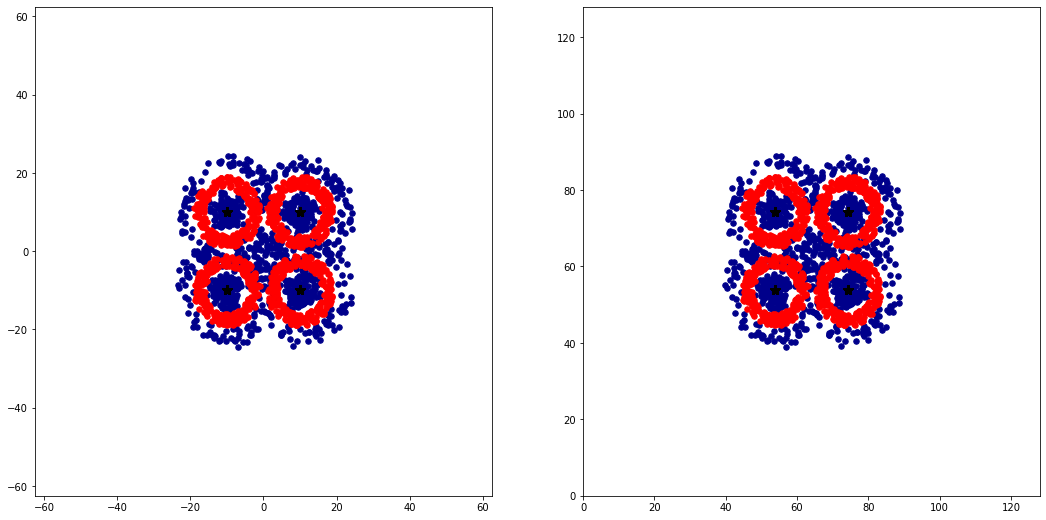

In [13]:
up_ev = -1
plt.figure(figsize=(18, 9))


#plt.scatter(Pi0_Y_pos, Pi0_X_pos, c="black", s=30)
#plt.scatter(Trk_Y_pos, Trk_X_pos, c="purple", s=30)

#Make Pi Pos at second Layer
zpos=Z[1]#-length[1]/2

Pi0_X_L2, Pi0_Y_L2=Make_Pi0_Pos(zpos)
Trk_X_L2, Trk_Y_L2=Make_Trk_Pos(zpos)

plt.subplot(121)
plt.scatter(Pi0_Y_L2, Pi0_X_L2, c="darkblue", s=30)
plt.scatter(Trk_Y_L2, Trk_X_L2, c="red", s=30)
plt.scatter(Ev_Y_or, Ev_X_or, c="black", marker="*", s=100)
plt.xlim(-det_size/2., det_size/2.)
plt.ylim(-det_size/2., det_size/2.)

Pi0_X_L2_pix, Pi0_Y_L2_pix=conv_to_pix(Pi0_X_L2), conv_to_pix(Pi0_Y_L2)
Trk_X_L2_pix, Trk_Y_L2_pix=conv_to_pix(Trk_X_L2), conv_to_pix(Trk_Y_L2)
Ev_X_or_pix, Ev_Y_or_pix=conv_to_pix(Ev_X_or), conv_to_pix(Ev_Y_or)

plt.subplot(122)
plt.scatter(Pi0_Y_L2_pix, Pi0_X_L2_pix, c="darkblue", s=30)
plt.scatter(Trk_Y_L2_pix, Trk_X_L2_pix, c="red", s=30)

plt.scatter(Ev_Y_or_pix, Ev_X_or_pix, c="black", marker="*", s=100)
plt.xlim(0, true_pix)
plt.ylim(0, true_pix)

plt.show()

In [14]:
#Pi0_X_L2_cm, Pi0_Y_L2_cm=conv_to_cm(Pi0_X_L2_pix), conv_to_cm(Pi0_Y_L2_pix)
#Trk_X_L2_cm, Trk_Y_L2_cm=conv_to_cm(Trk_X_L2_pix), conv_to_cm(Trk_Y_L2_pix)
##Ev_X_or_pix, Ev_Y_or_pix=conv_to_pix(Ev_X_or), conv_to_pix(Ev_Y_or)
#plt.hist(Pi0_X_L2_cm)
#
#
#plt.figure(figsize=(18, 9))
#
#plt.subplot(111)
#plt.scatter(Pi0_Y_L2_cm, Pi0_X_L2_cm, c="darkblue", s=30)
#plt.scatter(Pi0_Y_L2, Pi0_X_L2, c="red", s=30)

#plt.scatter(Ev_Y_or_pix, Ev_X_or_pix, c="black", marker="*", s=100)
#plt.xlim(0, true_pix)
#plt.ylim(0, true_pix)


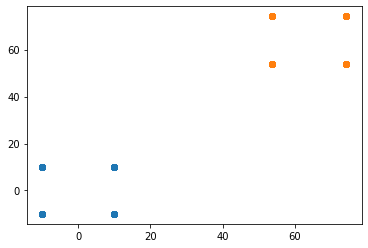

In [15]:
plt.scatter(Ev_Y_or, Ev_X_or)
plt.scatter(Ev_Y_or_pix, Ev_X_or_pix)


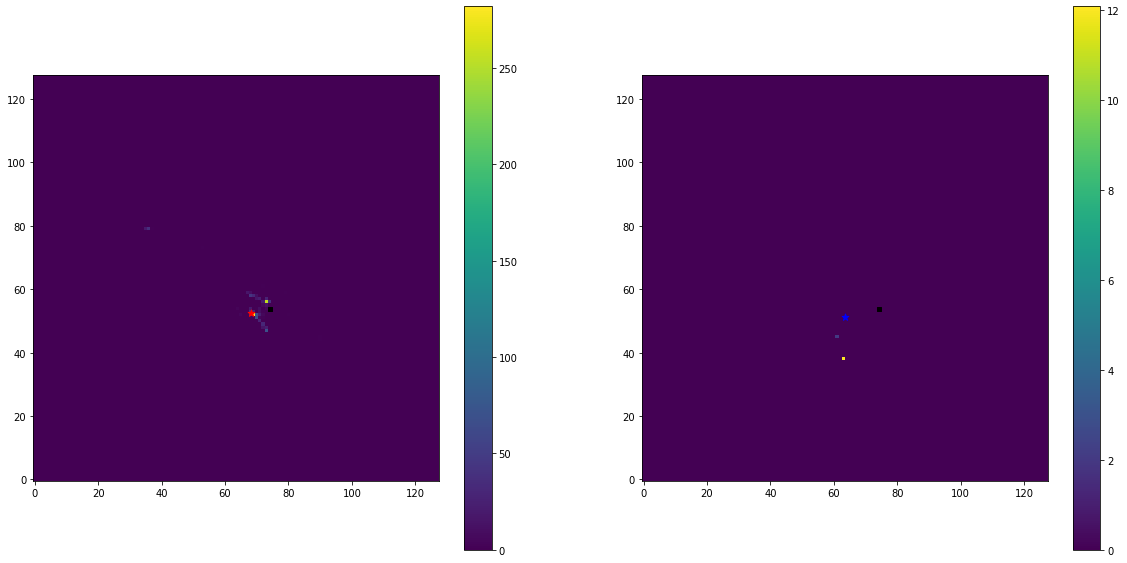

In [16]:
ev, l = 3, 0
plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(Ch_Layer_Orig[ev][l].T)
plt.gca().invert_yaxis()
plt.colorbar()

plt.scatter(Trk_X_L2_pix[ev],Trk_Y_L2_pix[ev], c="red", marker="*", s=50)

plt.scatter(Ev_X_or_pix[ev],Ev_Y_or_pix[ev], c="black", marker="s", s=20)

plt.subplot(122)
plt.imshow(Nu_Layer_Orig[ev][l].T)
plt.gca().invert_yaxis()
plt.colorbar()

plt.scatter(Pi0_X_L2_pix[ev],Pi0_Y_L2_pix[ev], c="blue", marker="*", s=50)

plt.scatter(Ev_X_or_pix[ev],Ev_Y_or_pix[ev], c="black", marker="s", s=20)

plt.show()

#print(Ev_X_or[ev], Ev_Y_or[ev])
#print(int(Trk_Y_L2_pix[ev]+0.5),int(Trk_X_L2_pix[ev]+0.5))
#print(Ch_Layer_Orig[ev][l][int(Trk_X_L2_pix[ev]+0.5),int(Trk_Y_L2_pix[ev]+0.5)])

In [20]:
ev, l = 22, 1
def invmass(pmu):
    return m.sqrt(pmu[0]**2-pmu[1]**2-pmu[2]**2-pmu[3]**2)

NEv=200

s_phot=np.zeros(NEv)
s_pi=np.zeros(NEv)
E_tot=np.zeros(NEv)

for ev in range(NEv):
    if ev % 10==0: print("____ EV : ", ev)
    Et = 0
    px = 0
    py = 0
    pz = 0
    
    coord = []
    energy = []
    En = Nu_Layer_Orig[ev][l]
    DZ=Z[1]#-length[1]/2.
    for X in range(true_pix):
        for Y in range(true_pix):
            if En[X][Y]!=0:
                coord.append([X, Y])
                energy.append(En[X][Y])
    
                DX=conv_to_cm(X)-conv_to_cm(Ev_X_or_pix[ev])
                DY=conv_to_cm(Y)-conv_to_cm(Ev_Y_or_pix[ev])
                
                r=m.sqrt(DX**2 + DY**2 + DZ**2)
                
                #Et+=En[X][Y]
                px+= DX * En[X][Y]/r
                py+= DY * En[X][Y]/r
                pz+= DZ * En[X][Y]/r
    
    if len(energy)==0: continue
            
    
    coord = np.asarray(coord)
    energy= np.asarray(energy)
    
    kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=100, random_state=0)
    predictions = kmeans.fit(coord, sample_weight=energy)
    
    ph_1 = kmeans.cluster_centers_[0]
    ph_2 = kmeans.cluster_centers_[1]
    
    DX_1 = conv_to_cm(ph_1[0])-conv_to_cm(Ev_X_or_pix[ev])
    DY_1 = conv_to_cm(ph_1[1])-conv_to_cm(Ev_Y_or_pix[ev])
    DX_2 = conv_to_cm(ph_2[0])-conv_to_cm(Ev_X_or_pix[ev])
    DY_2 = conv_to_cm(ph_2[1])-conv_to_cm(Ev_Y_or_pix[ev])
    
    R_1 = m.sqrt(DX_1**2+DY_1**2+DZ**2)
    R_2 = m.sqrt(DX_2**2+DY_2**2+DZ**2)
    
    E_ph_1 = np.sum(energy[np.where(predictions.labels_==1)])
    E_ph_2 = np.sum(energy[np.where(predictions.labels_==0)])
    
    pT_1 = np.asarray([E_ph_1, DX_1*E_ph_1/R_1, DY_1*E_ph_1/R_1, DZ*E_ph_1/R_1])
    pT_2 = np.asarray([E_ph_2, DX_2*E_ph_2/R_2, DY_2*E_ph_2/R_2, DZ*E_ph_2/R_2])
    
    pT_tot = pT_1+pT_2 
    pT_pi= np.asarray([pT_tot[0],px, py, pz])

    
    s_phot[ev]=invmass(pT_tot)
    s_pi[ev]=invmass(pT_pi)
#print(s_phot)
#print(s_pi)

____ EV :  0
____ EV :  10
____ EV :  20
____ EV :  30
____ EV :  40
____ EV :  50
____ EV :  60
____ EV :  70
____ EV :  80
____ EV :  90
____ EV :  100
____ EV :  110
____ EV :  120
____ EV :  130
____ EV :  140
____ EV :  150
____ EV :  160
____ EV :  170
____ EV :  180
____ EV :  190


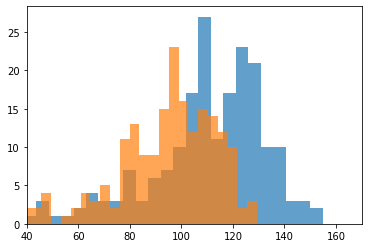

In [19]:
plt.hist(s_pi, alpha=0.7, bins=50)
plt.hist(s_phot, alpha=0.7, bins=50)
plt.xlim(40, 170)
plt.show()

In [122]:
print(kmeans.cluster_centers_)
pp=(Et,px, py, pz)
print(invmass(pp), pp)

AttributeError: 'KMeans' object has no attribute 'cluster_centers_'

In [92]:
ph_1=kmeans.cluster_centers_[0]
ph_2=kmeans.cluster_centers_[1]

DX_1 = -(Ev_X_or_pix[ev]-ph_1[0])*det_size/true_pix
DY_1 = -(Ev_Y_or_pix[ev]-ph_1[1])*det_size/true_pix
DX_2 = -(Ev_X_or_pix[ev]-ph_2[0])*det_size/true_pix
DY_2 = -(Ev_Y_or_pix[ev]-ph_2[1])*det_size/true_pix

#print(DX_1, DY_1)
#print(DX_2, DY_2)

R_1=m.sqrt(DX_1**2+DY_1**2+DZ**2)
R_2=m.sqrt(DX_2**2+DY_2**2+DZ**2)

#print(R_1, R_2)

In [93]:
E_ph_1=np.sum(energy[np.where(predictions.labels_==1)])
E_ph_2=np.sum(energy[np.where(predictions.labels_==0)])
print(E_ph_1, E_ph_2)

1370.5591 1078.1528


In [94]:
pT_1=np.asarray([E_ph_1, DX_1*E_ph_1/R_1, DY_1*E_ph_1/R_1, DZ*E_ph_1/R_1])

pT_2=np.asarray([E_ph_2, DX_2*E_ph_2/R_2, DY_2*E_ph_2/R_2, DZ*E_ph_2/R_2])

pT_tot=pT_1+pT_2 

print(pT_1)
print(pT_2)
print(pT_tot)

[1370.55908203   24.14820557   64.23604316 1368.83994399]
[1078.15283203   96.85020751   23.57494181 1073.53518277]
[2448.71191406  120.99841308   87.81098496 2442.37512676]


In [95]:
def invmass(pmu):
    return m.sqrt(pmu[0]**2-pmu[1]**2-pmu[2]**2-pmu[3]**2)


In [96]:
s=invmass(pT_tot)
print(s)

92.96447283754249


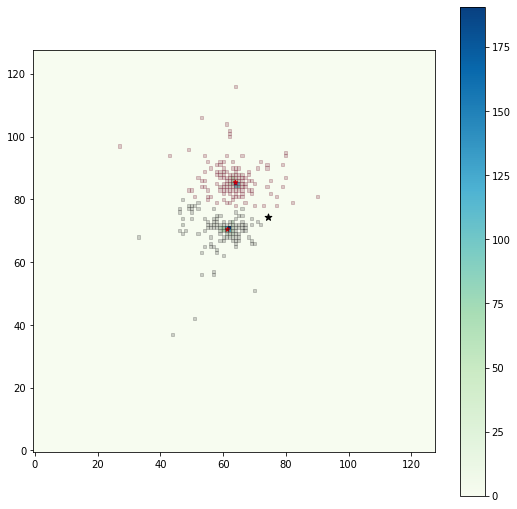

In [70]:
plt.figure(figsize=(9, 9))
#plt.scatter(poi[:,0], poi[:,1], c="black")
plt.imshow(Nu_Layer_Orig[ev][l], cmap="GnBu", alpha=1)
plt.gca().invert_yaxis()
plt.colorbar()
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=20, c='red', marker ='*')
plt.scatter(posit[:,0], posit[:,1], c=pred_y.labels_.astype(float),s=10,cmap='RdGy',marker='s', alpha=0.2)
plt.scatter(Ev_Y_or_pix[ev],Ev_X_or_pix[ev], c="black", marker="*", s=50)

plt.show()

In [32]:
print(len(X))
print(len(pred_y.labels_.astype(float))

SyntaxError: unexpected EOF while parsing (<ipython-input-32-e1d8ae7d10c6>, line 2)

In [157]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(poi, sample_weight=weigh)

plt.figure(figsize=(11, 11))
plt.scatter(poi[:,0], poi[:,1],c=pred_y.labels_.astype(float))
#plt.imshow(Nu_Layer_Orig[ev][l], cmap="OrRd_r")
#plt.gca().invert_yaxis()
plt.colorbar()
plt.scatter(kmeans.cluster_centers_[:, 0], pred_y.cluster_centers_[:, 1], s=50, c='black', marker ='*')
plt.show()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)


AttributeError: 'numpy.ndarray' object has no attribute 'labels_'

<Figure size 1100x1100 with 0 Axes>

      Pct_Spend_in_Organic  Pct_Spend_in_Local
0                 6.666011            2.421987
1                18.214584           10.729393
2                15.714767           10.651138
3                 7.898742            1.364515
4                 9.351868            3.672406
...                    ...                 ...
4995              8.330355            2.507292
4996             18.411906           11.998805
4997              8.791952            3.091321
4998             18.154177           13.114608
4999             16.423615           13.209479

[5000 rows x 2 columns]


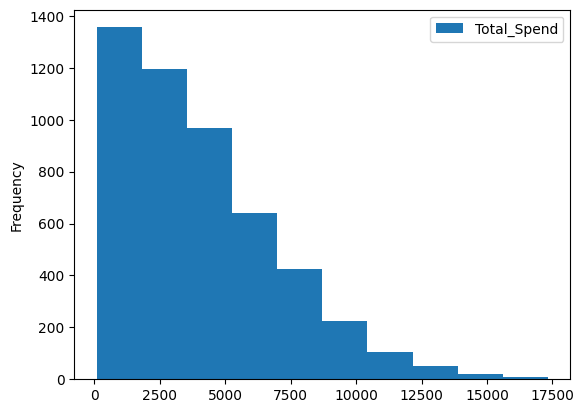

In [145]:
X, y = make_blobs(n_samples=5000, centers=4, n_features=2, random_state=25)
df = DataFrame(dict(Pct_Spend_in_Organic=(X[:,0])+10, Pct_Spend_in_Local=(X[:,1])+10))
df['Total_Spend']=(skewnorm.rvs(1000,size=5000)*5000)+100
ax=df.reset_index().plot(x='index',y="Total_Spend",kind="hist")

In [146]:
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=10)
X = poi
Y = weigh

Text(0, 0.5, 'Pct Spend in Organic')

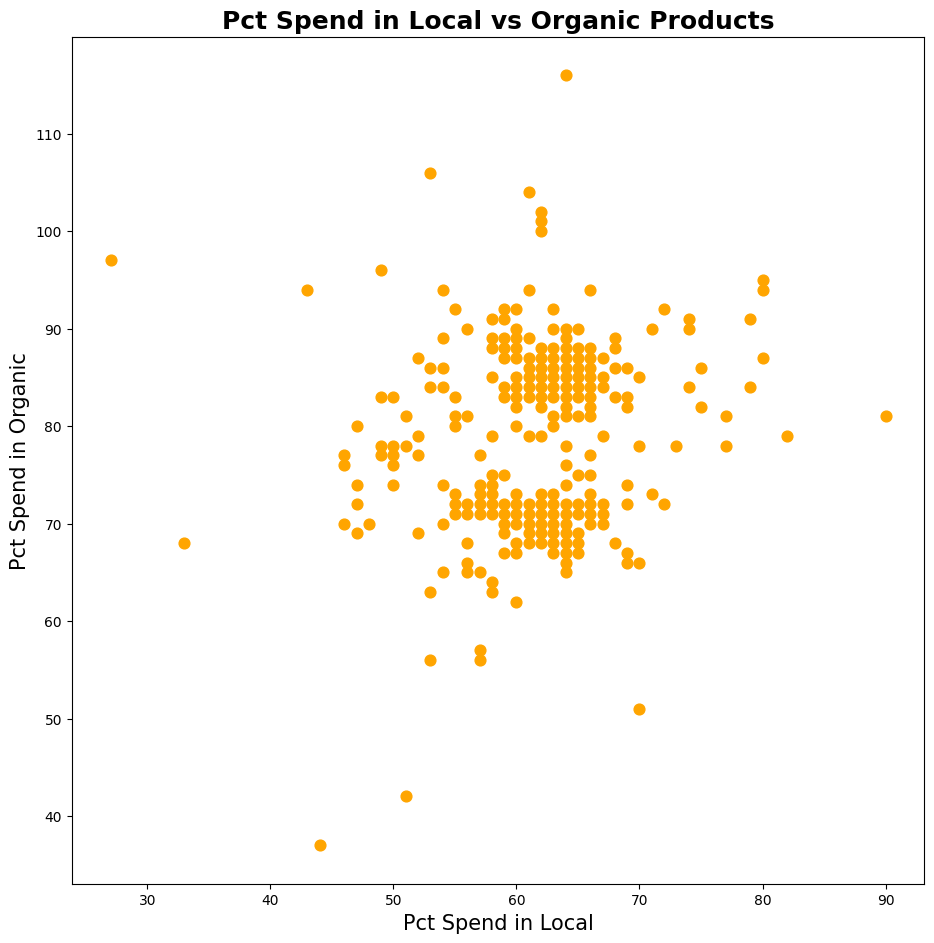

In [152]:
plt.style.use('default')
#x=np.array(df['Pct_Spend_in_Local'])
#y=np.array(df['Pct_Spend_in_Organic'])
plt.figure(figsize=(11, 11))
plt.scatter(X[:, 0], X[:,1], s=60, cmap='viridis',c='orange',label='Spend in Organic Products')
plt.title('Pct Spend in Local vs Organic Products',fontsize=18, fontweight='bold')
plt.xlabel('Pct Spend in Local',fontsize=15)
plt.ylabel('Pct Spend in Organic',fontsize=15)

In [164]:
#print(X)
wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
predicted_kmeans = kmeans.predict(X, sample_weight = Y)
predicted_kmeans.shape

()

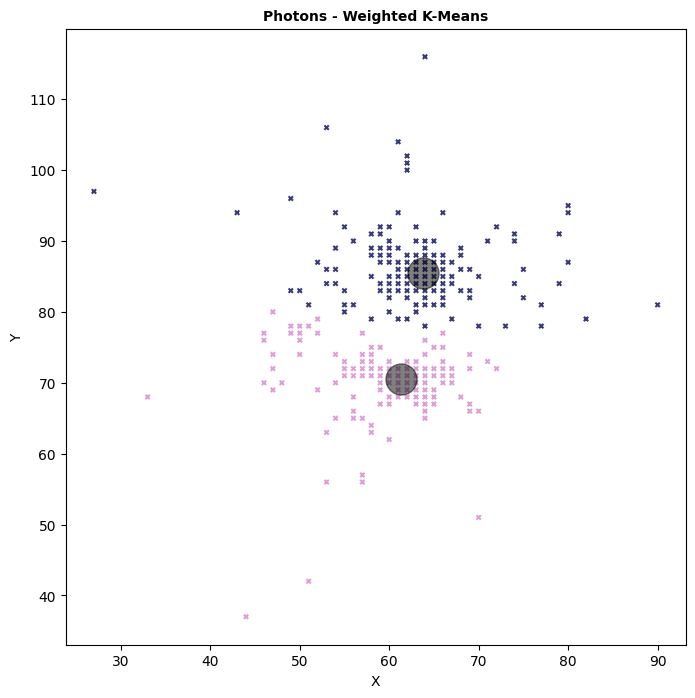

In [162]:
plt.style.use('default')
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=wt_kmeansclus.labels_.astype(float),s=10,cmap='tab20b',marker='x')
plt.title('Photons - Weighted K-Means',fontsize=10, fontweight='bold')
plt.xlabel('X',fontsize=10)
plt.ylabel('Y',fontsize=10)
centers = wt_kmeansclus.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500, alpha=0.5);